In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline
!pwd

/home/ikea/GraphLearn/GraphLearn_examples/Abstract


In [2]:
# get data
from itertools import islice
'''
Create a function that is able to deliver a graph iterator
'''
from eden.converter.fasta import fasta_to_sequence
from eden.converter.rna.rnafold import rnafold_to_eden

from eden.graph import Vectorizer
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)


def clean(graphs):
    for g in graphs:
        for n,d in g.nodes(data=True):
            if 'weight' in d:
                d.pop('weight')
        yield g


def rfam_uri(family_id):
    return '%s.fa'%(family_id)

def get_graphs(rfam_id = '../toolsdata/RF00005',size=9999):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    graphs = islice( clean(rnafold_to_eden(seqs, shape_type=5, energy_range=30, max_num=3)), size)
    return graphs


from eden.converter.fasta import fasta_to_sequence
import itertools


def get_sequences(size=9999):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    return [ b for (a,b) in sequences ]

def get_sequences_with_names(size=9999):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    return sequences


#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 


In [3]:
'''DEBUGGING PREPROCESSA'''

from graphlearn.utils import draw
import graphlearn.abstract_graphs.learned_RNA as learned
from eden.graph import Vectorizer
if False:
    # if we are not interested in what the pp does we can skip this because it is slow
    # it shows how the created abstractions look like.
    v=Vectorizer(triangular_decomposition=False,complexity=3)
    pp=learned.RnaPreProcessor(kmeans_clusters=3,structure_mod=False)
    pp.set_param(v)
    gm=pp.fit_transform(get_sequences_with_names(40))

    for i in range(10):
        draw.graphlearn([gm[i+5].graph(),gm[i+5].base_graph(),gm[i+5].abstract_graph()],size=13,contract=True, abstract_color='red')



In [4]:
import eden.RNA
eden.RNA.Vectorizer()

In [3]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.learned_RNA as learned
import graphlearn.abstract_graphs.RNA as rna
from graphlearn import feasibility
import graphlearn.estimator as estimator
graphs = get_sequences_with_names(200)

estimator=estimator.Wrapper( nu=.33, cv=2, n_jobs=-1)
feas=feasibility.FeasibilityChecker(checklist=[feasibility.default_check,rna.is_rna])

pp=learned.RnaPreProcessor(base_thickness_list=[2],kmeans_clusters=3,structure_mod=False)
sampler=rna.AbstractSampler(radius_list=[0,1],
                            thickness_list=[1], 
                            min_cip_count=1, 
                            min_interface_count=2,
                            feasibility_checker=feas, 
                            preprocessor=pp,
                            estimator=estimator)
sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
sampler.save('../tmp/rna_annotate.ge')

fit pp done
CPU times: user 2min 27s, sys: 31.8 s, total: 2min 59s
Wall time: 6min 29s


interface id: 826720 [12 options]


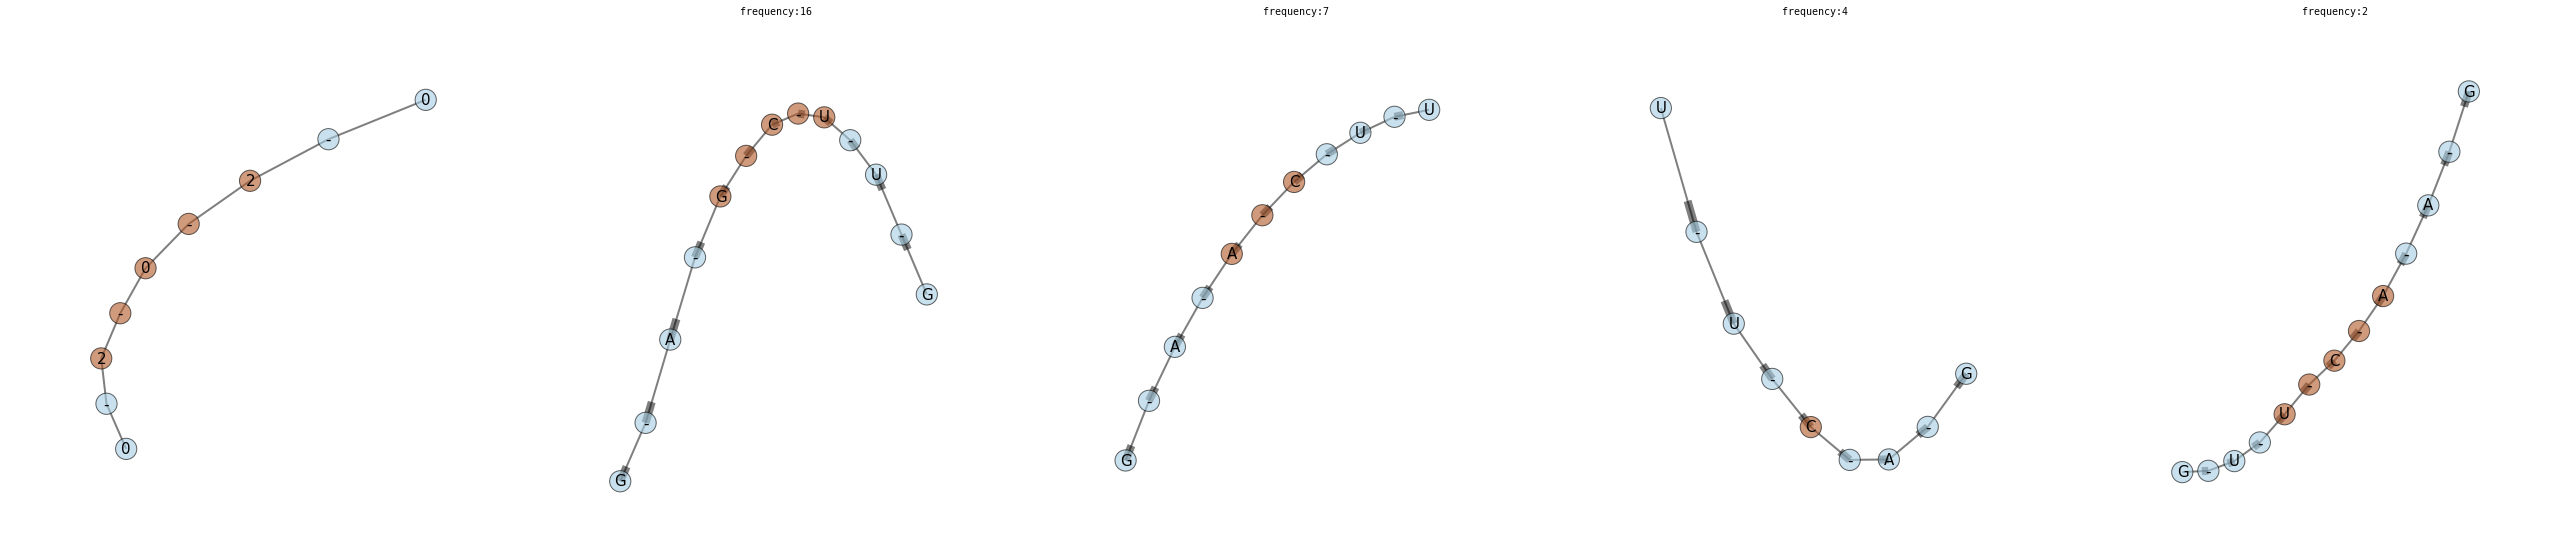

interface id: 910766 [11 options]


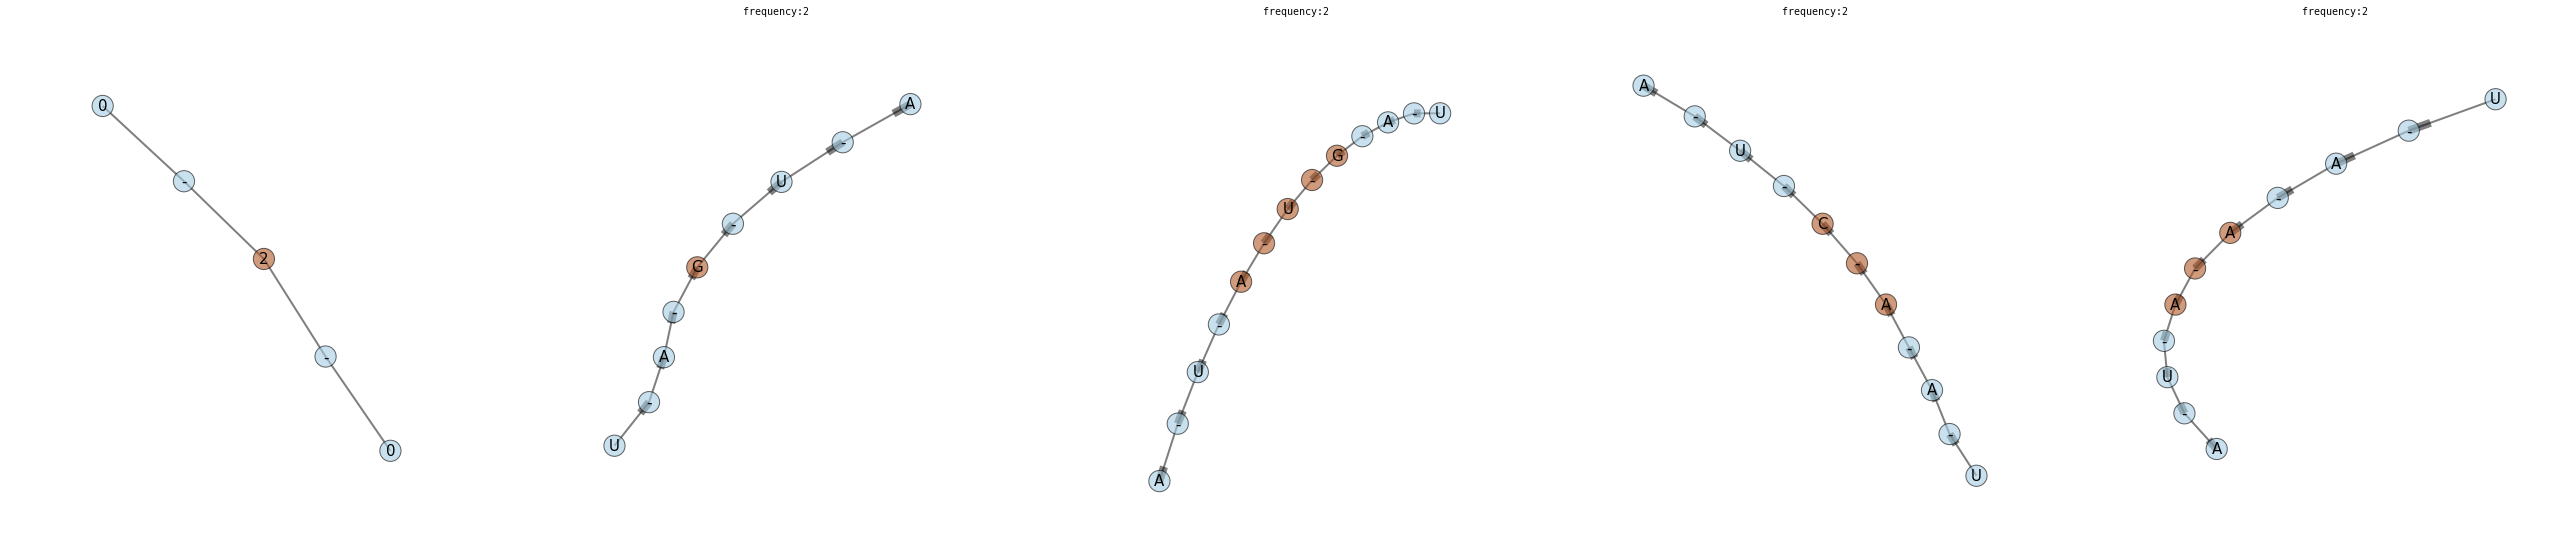

interface id: 1047612 [10 options]


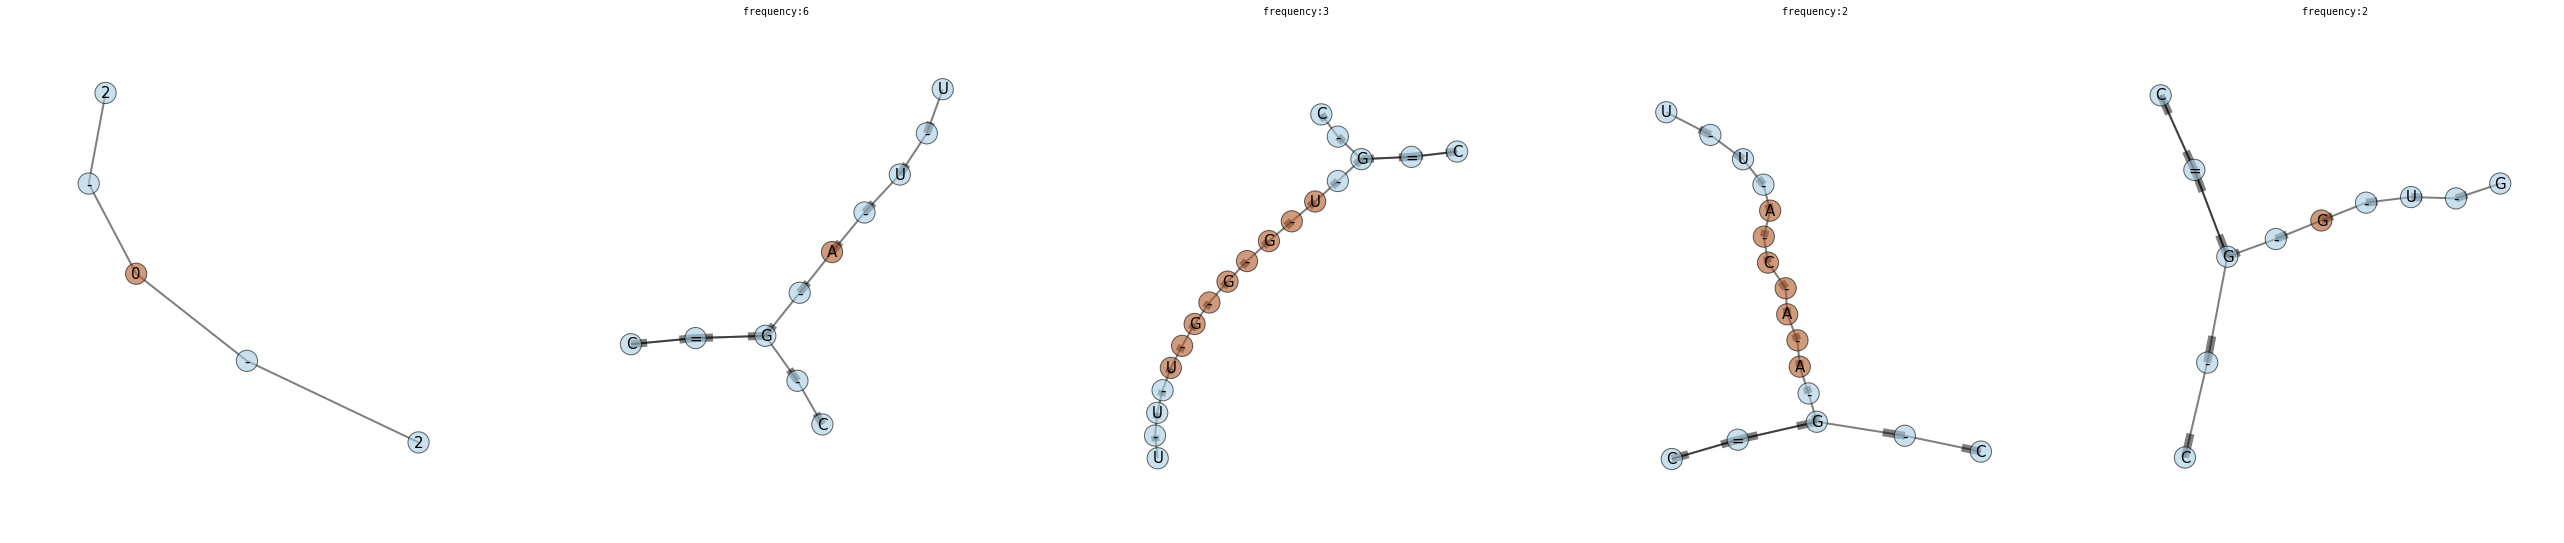

interface id: 899860 [10 options]


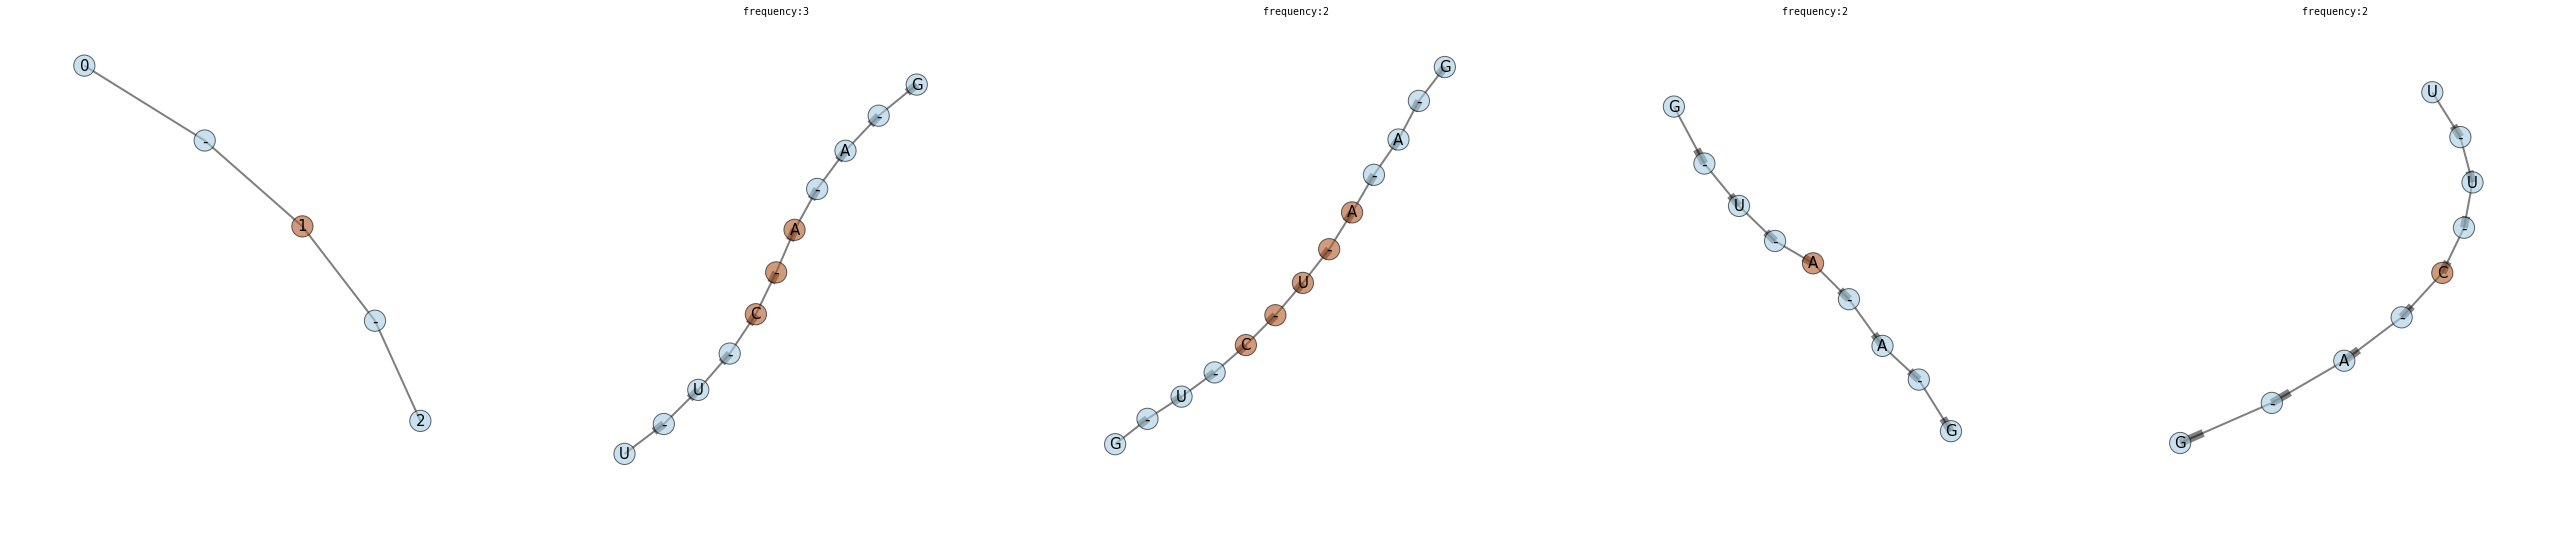

interface id: 861048 [10 options]


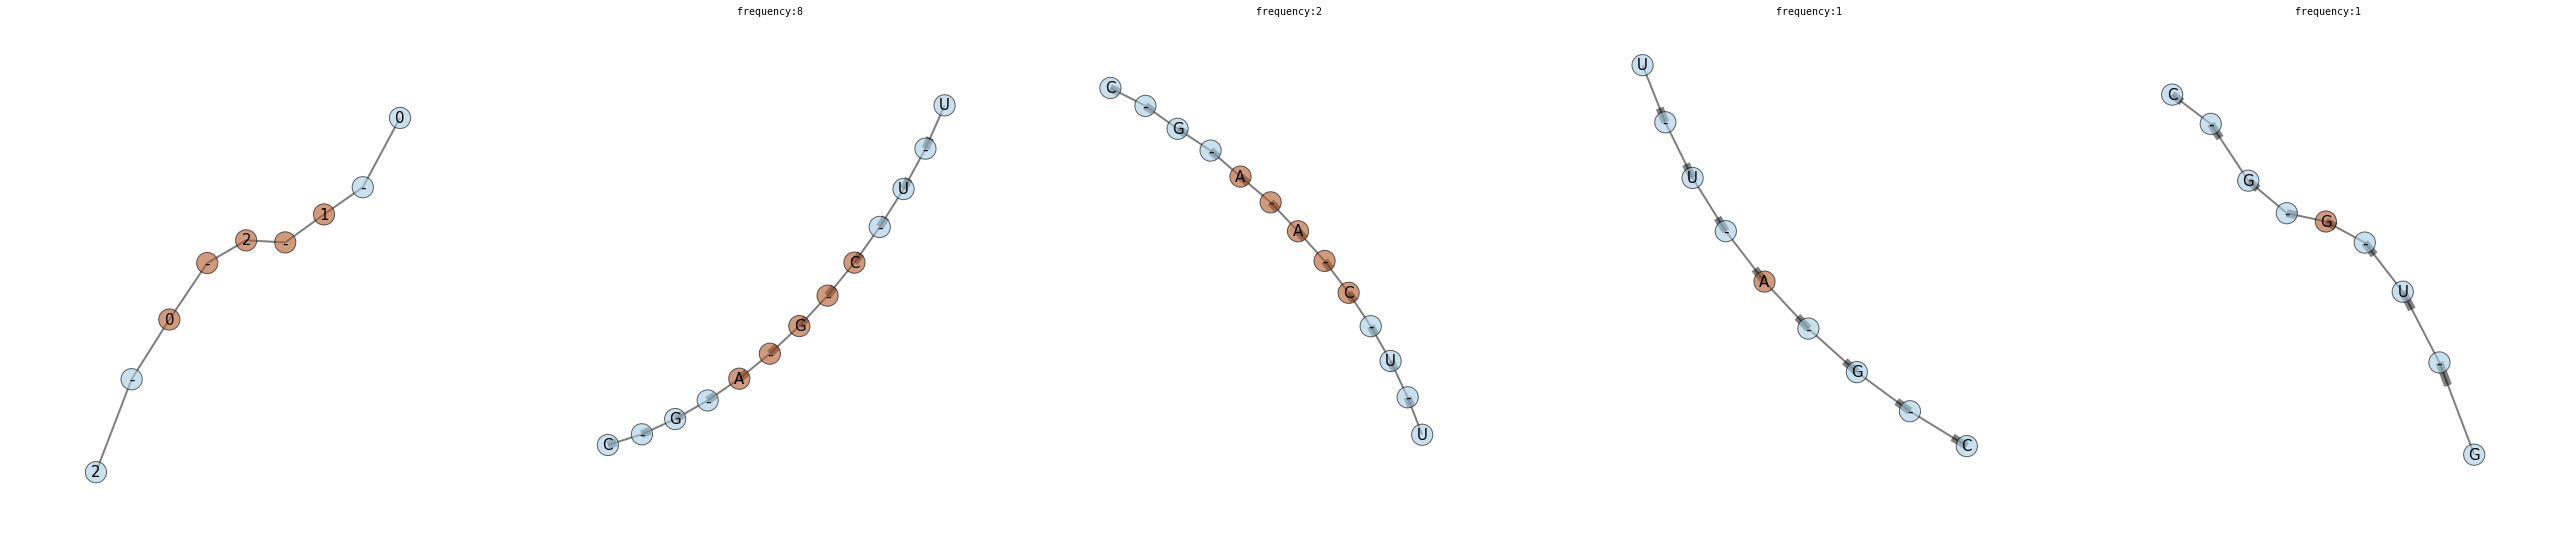

In [5]:
#draw production rules
from graphlearn.utils import draw
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)


Graph id: 66


/home/ikea/.local/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/ikea/.local/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


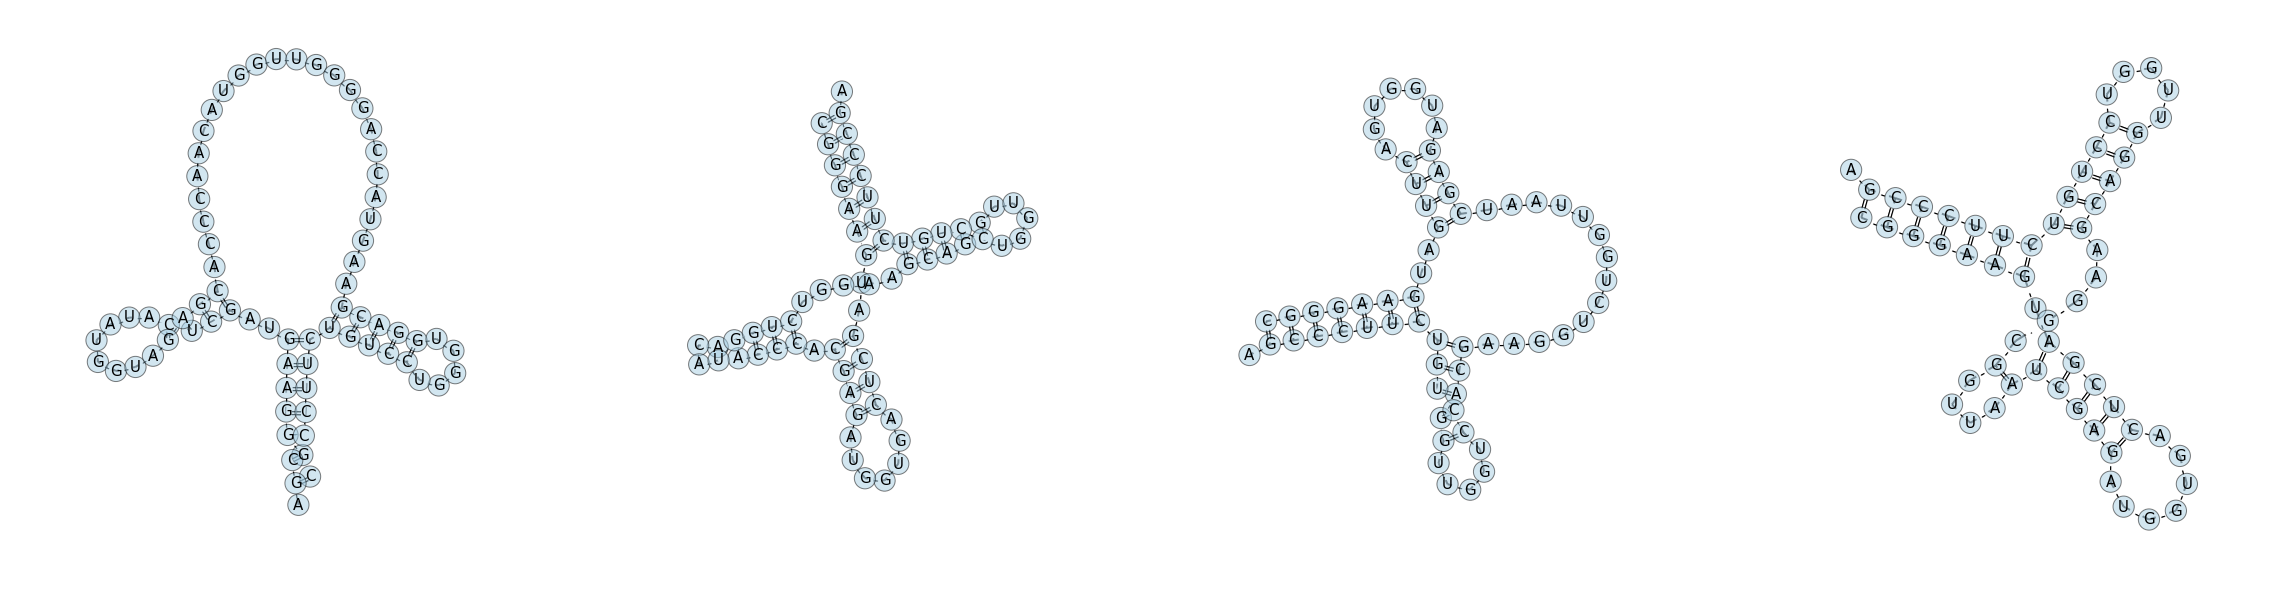

Graph id: 67


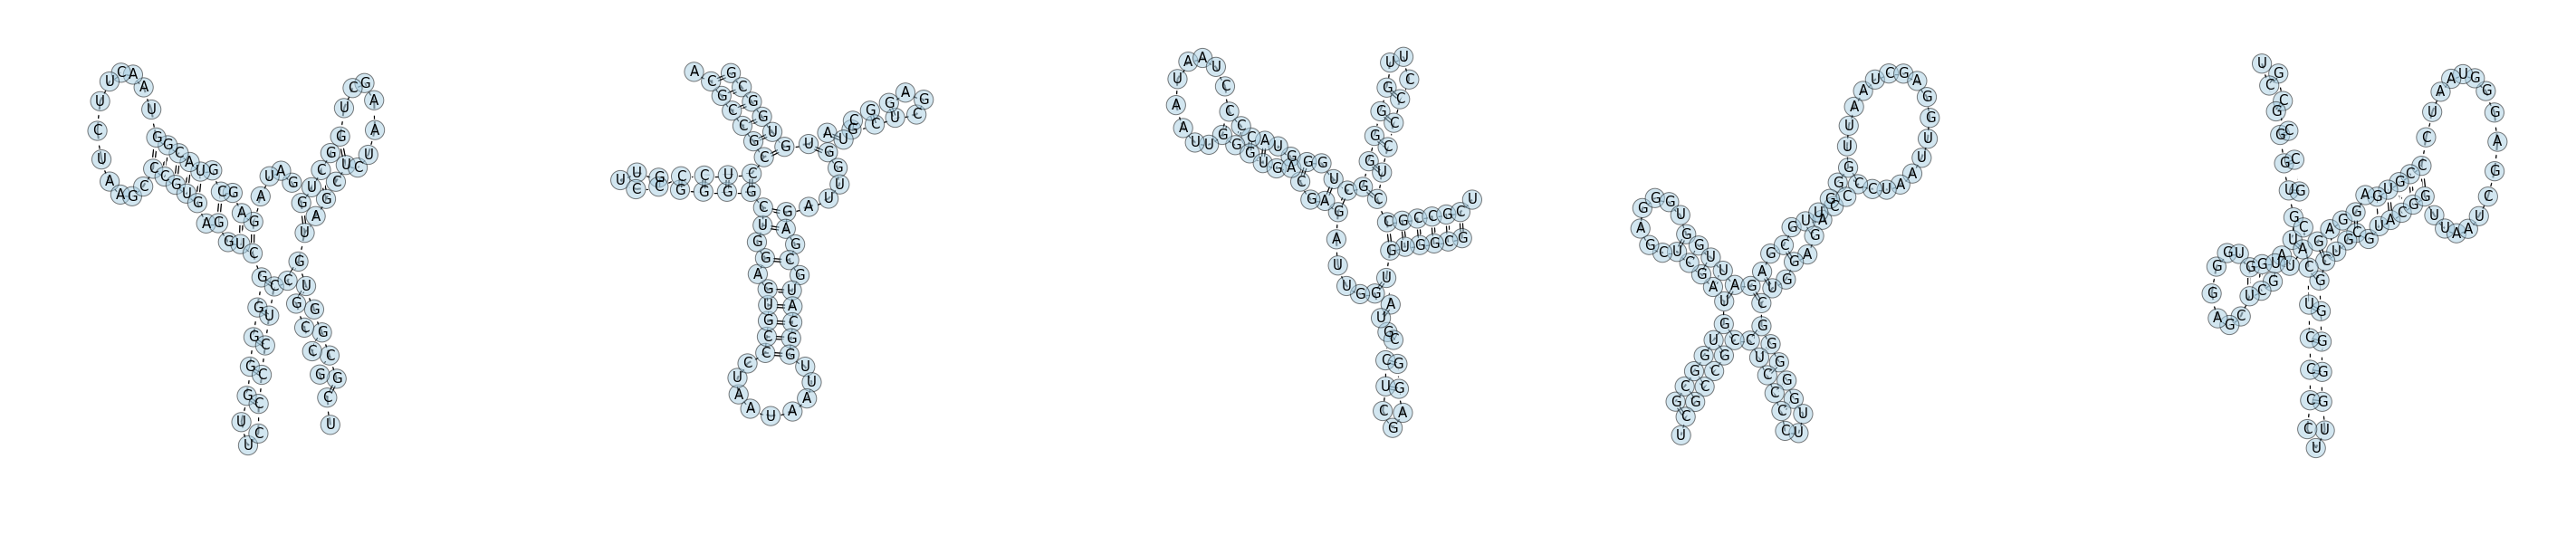

Graph id: 68


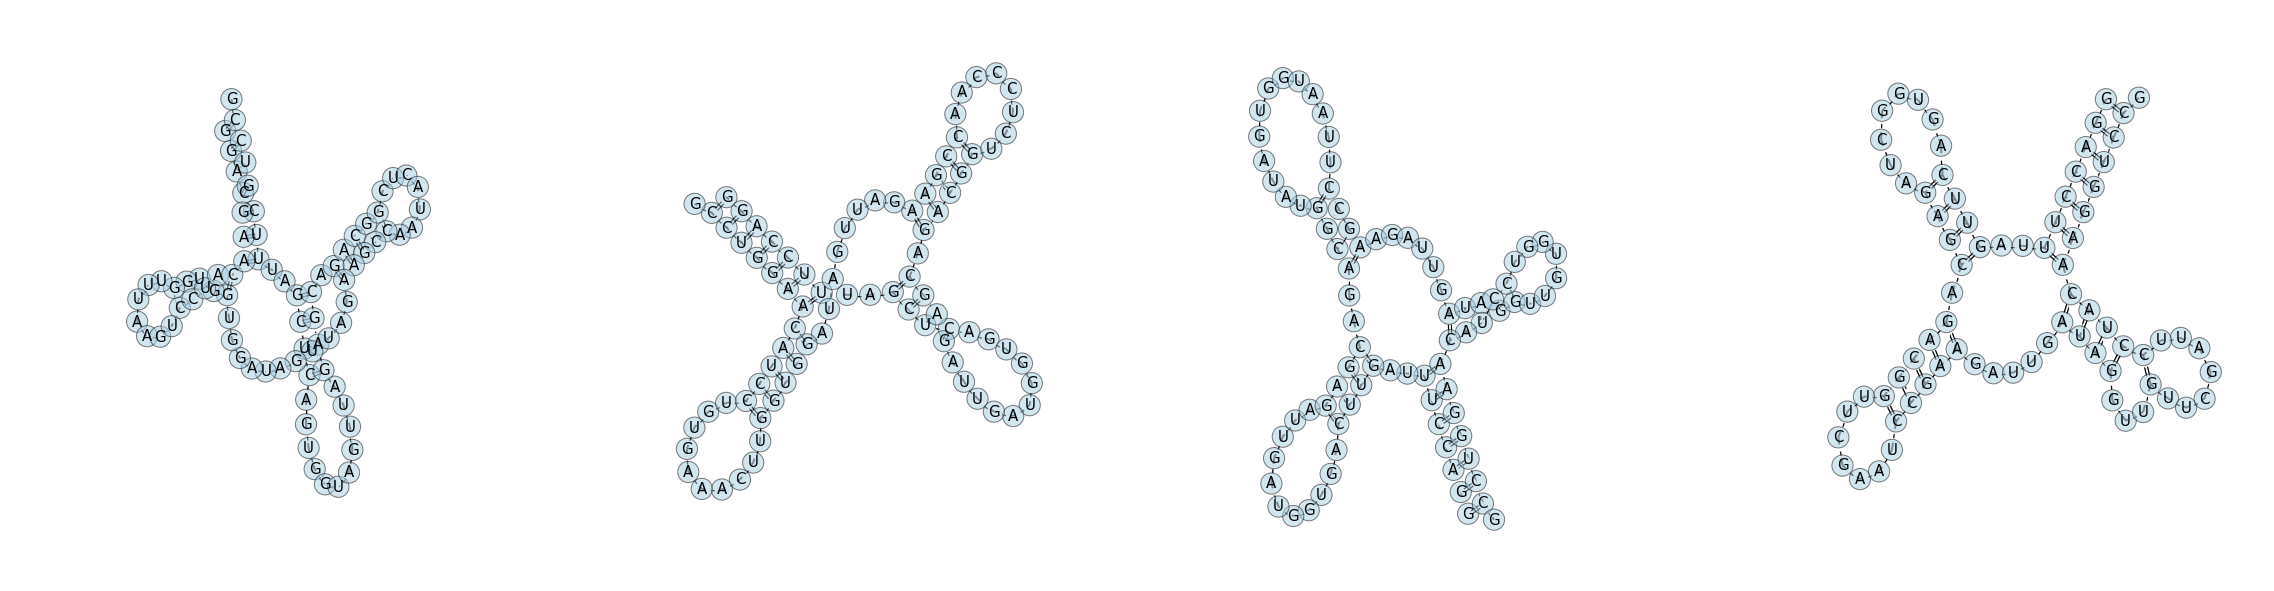

Graph id: 69


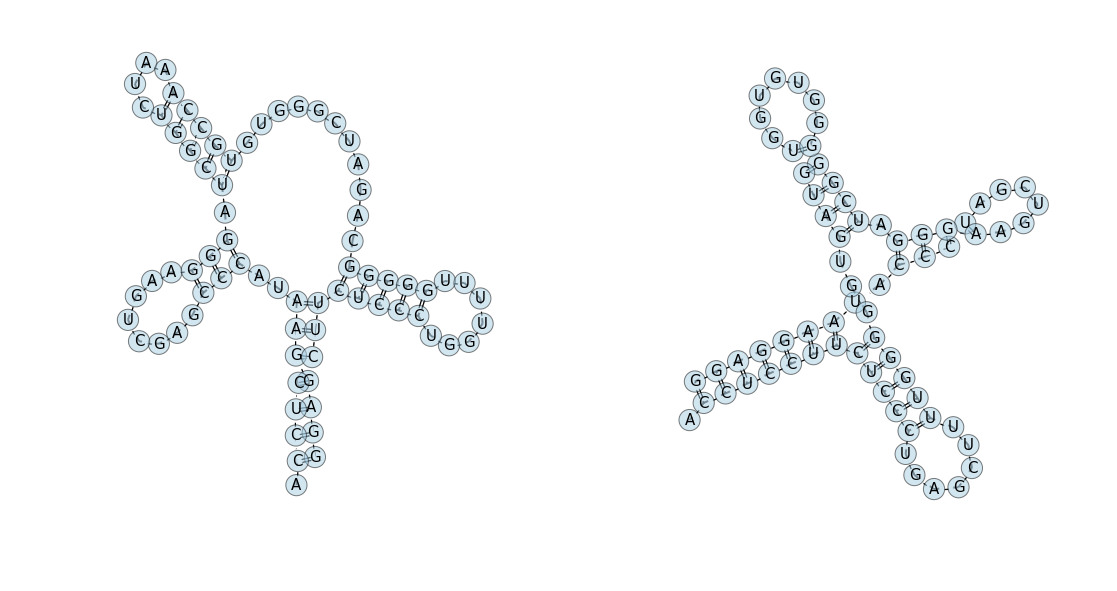

Graph id: 70


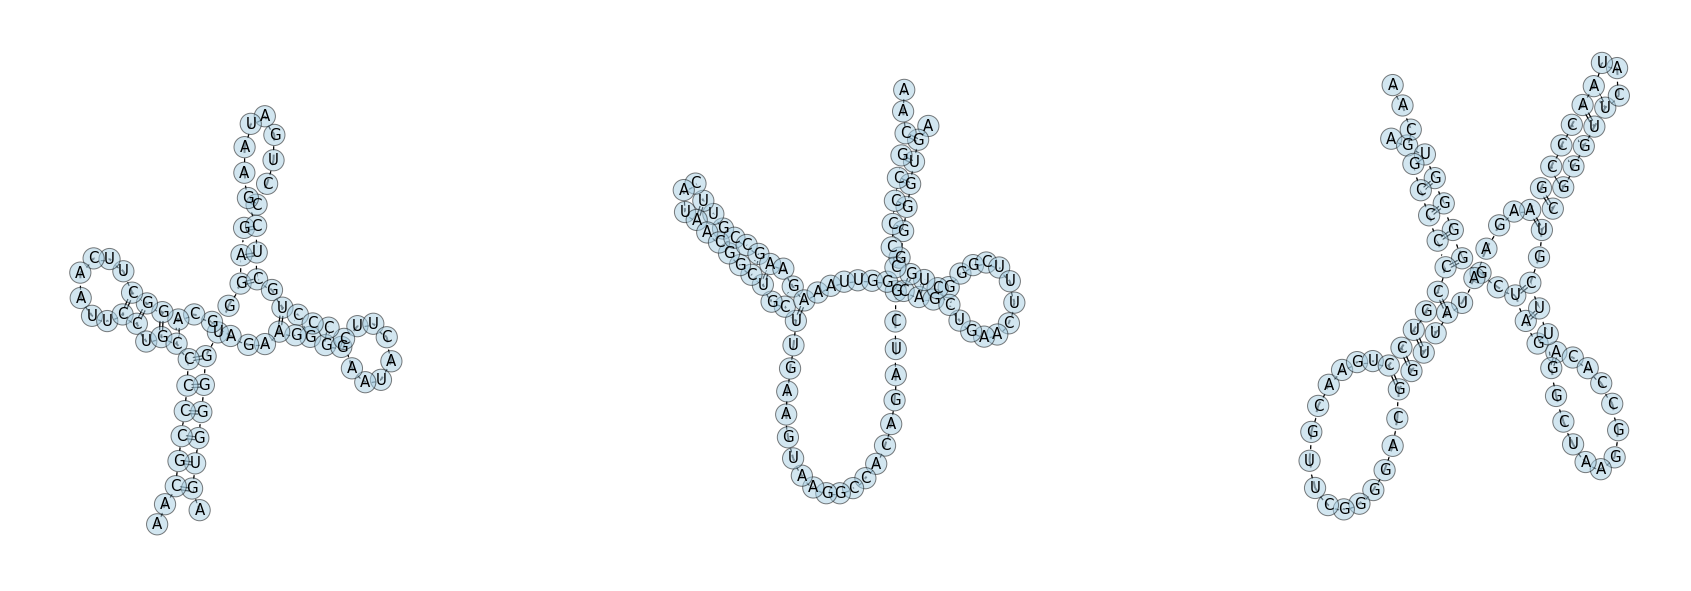

Graph id: 71


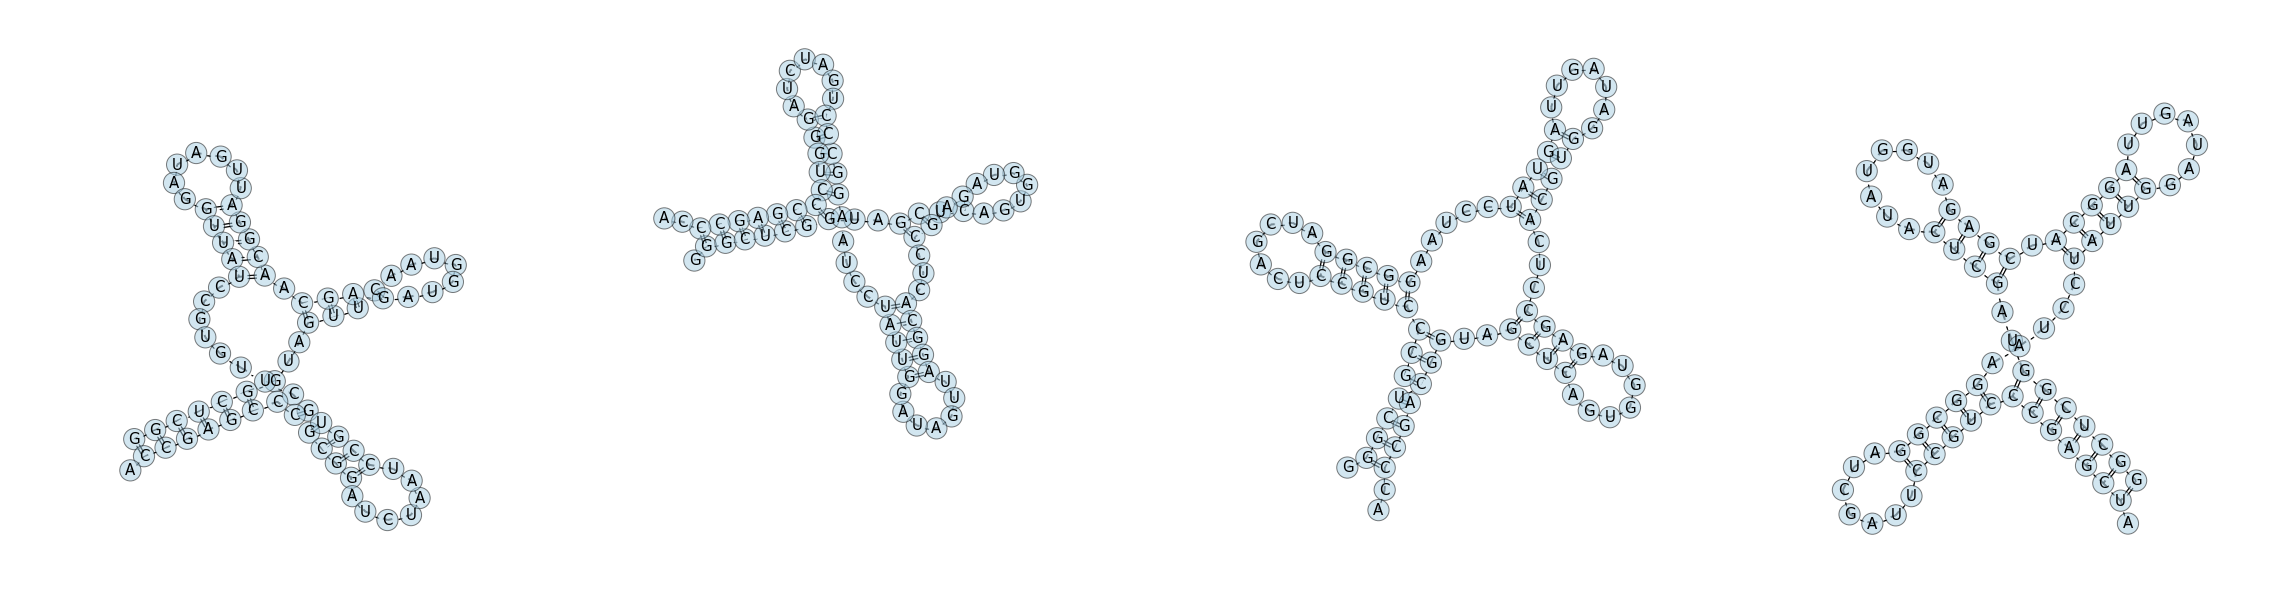

Graph id: 72


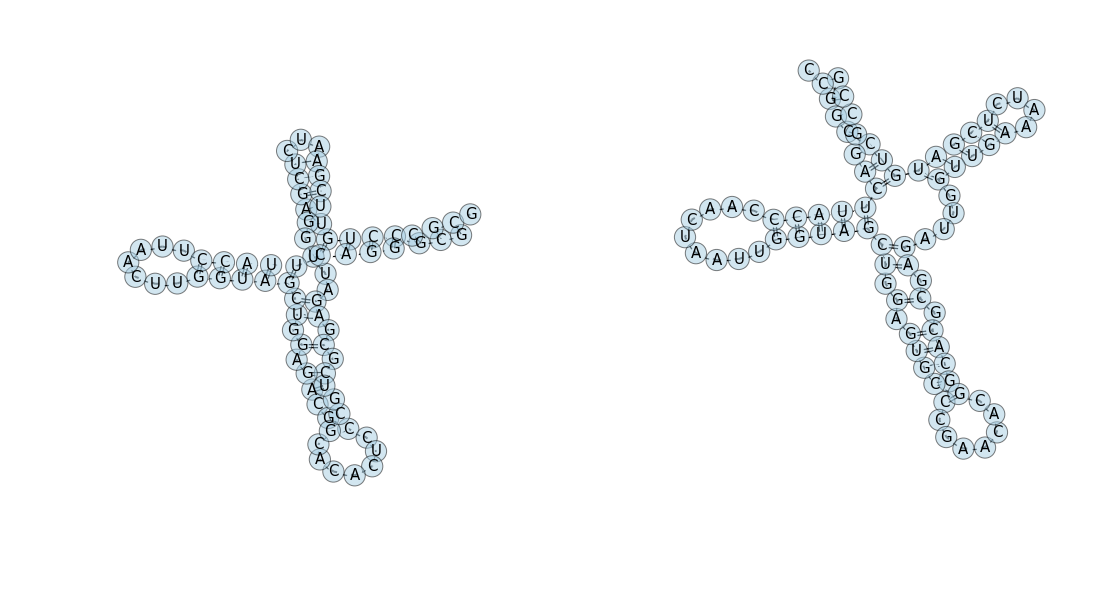

Graph id: 73


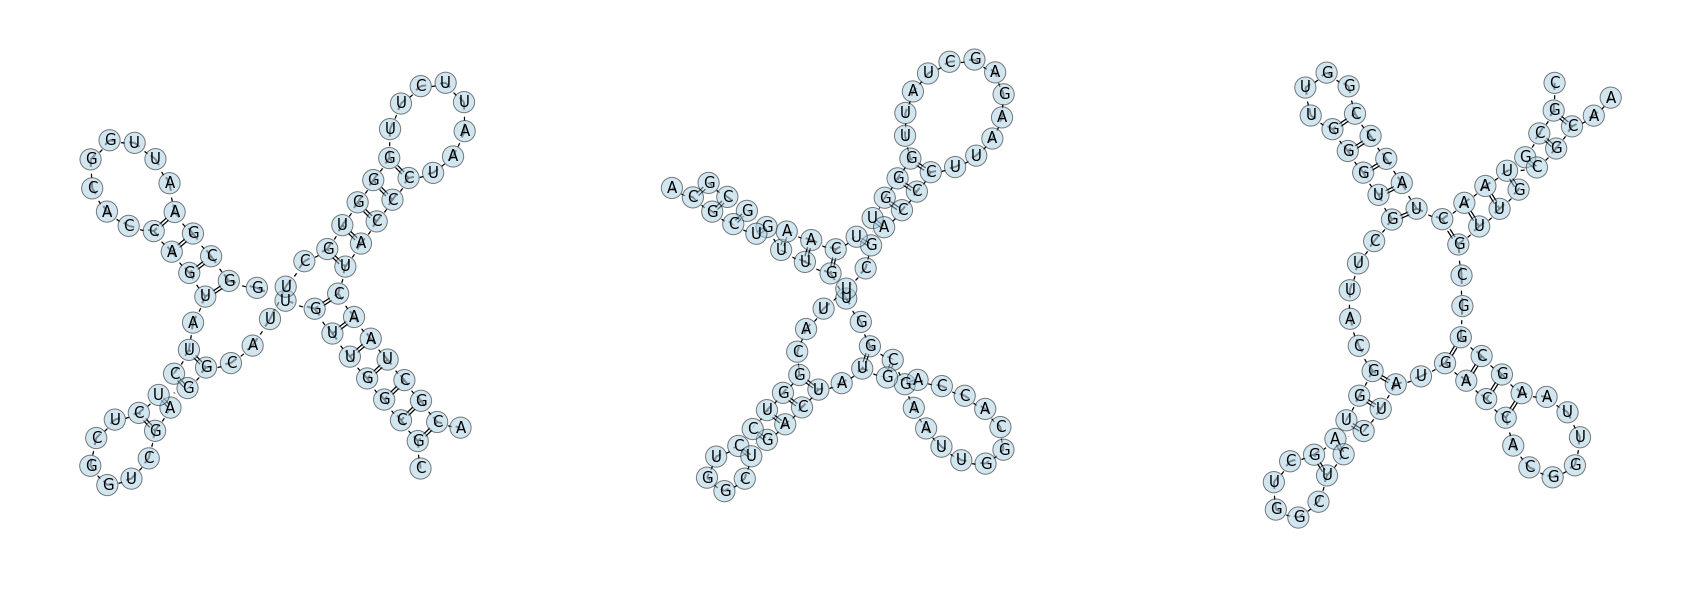

Graph id: 74


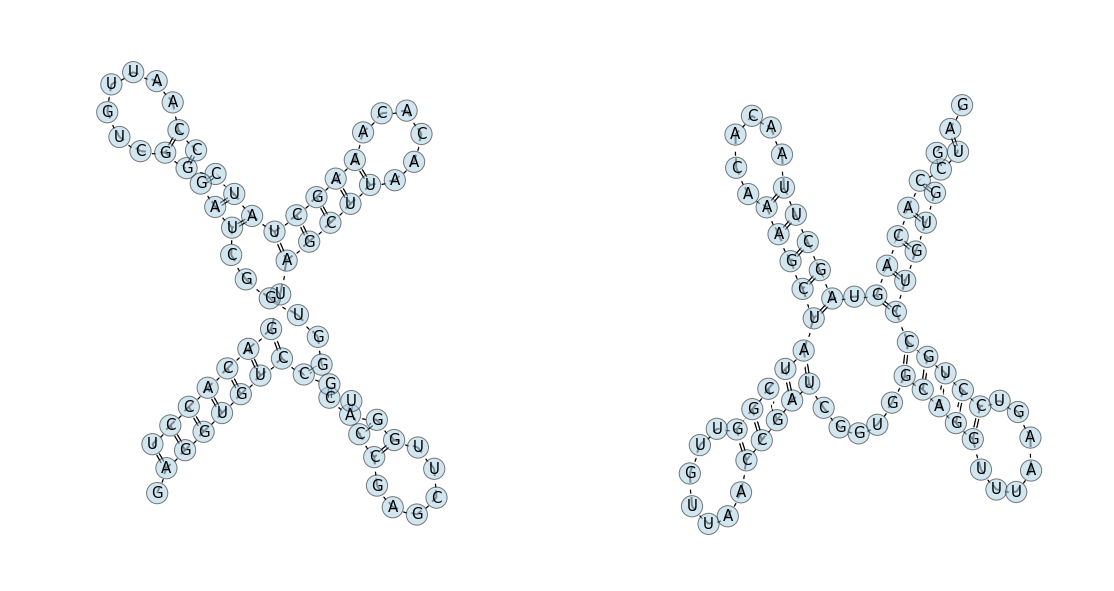

Graph id: 75


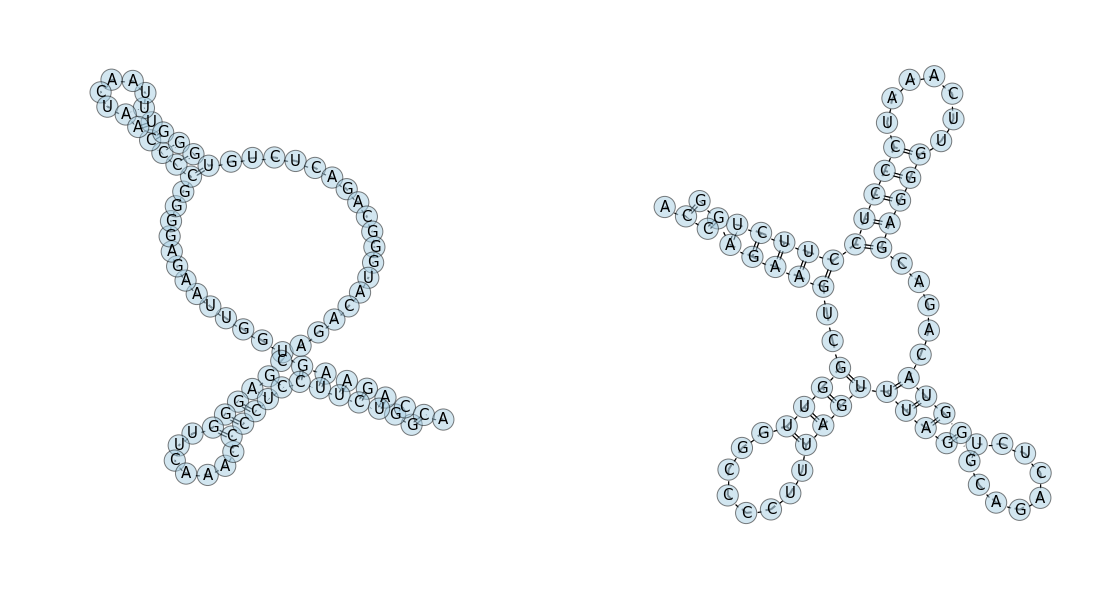

Graph id: 76


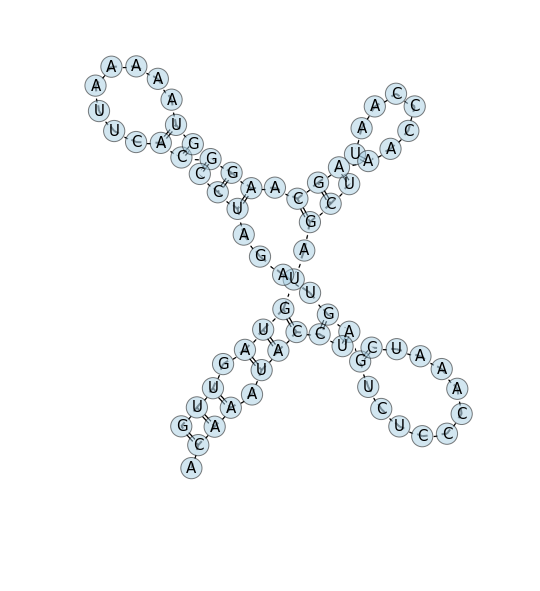

Graph id: 77


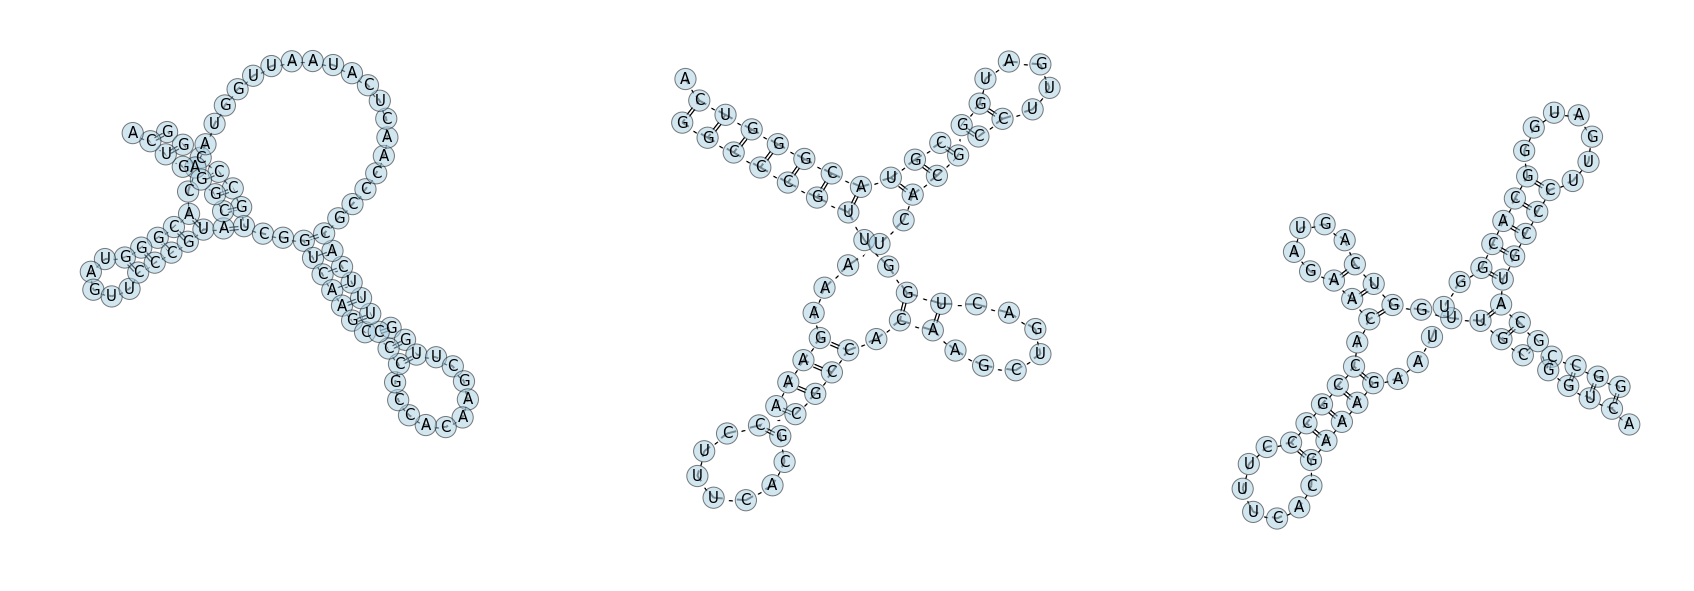

CPU times: user 51.4 s, sys: 8.84 s, total: 1min
Wall time: 6min 30s


In [6]:
%%time

import os
os.nice(19)
import graphlearn.utils.draw as draw
import itertools

graphs = get_sequences()

id_start=66
id_end=id_start+12
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100

graphs = sampler.sample(graphs,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=2,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.9,
                        improving_linear_start=0.1,
                        max_size_diff=20,
                        select_cip_max_tries=40,
                        keep_duplicates=False,
                        accept_min_similarity=0.55,
                        include_seed=True,
                        backtrack=10,
                        monitor=True)


scores=[]
sequences=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    path_graphs = graph
    sequences.append(sampler.monitors[i].sampling_info['notes'])    

    path_graphs= list(path_graphs)
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=5, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label'
                          
                          )
    

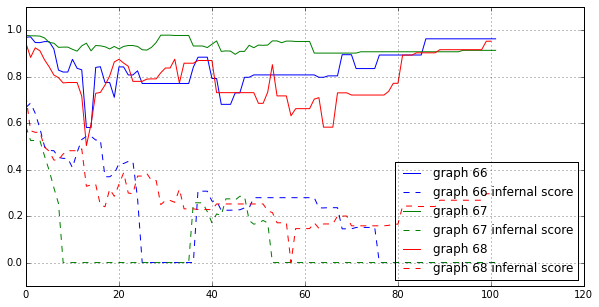

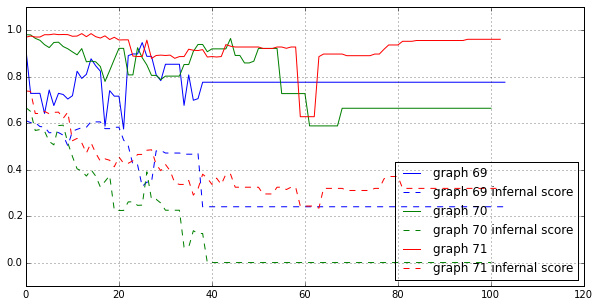

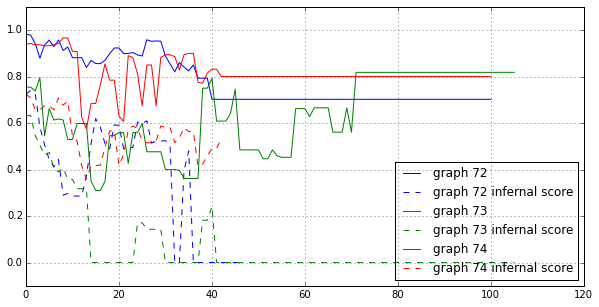

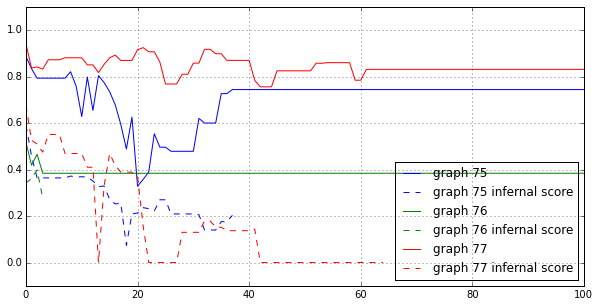

In [7]:
colors=['b','g','r','c','m','y','k','w']

%matplotlib inline
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data,ls='-',color=colors[j], label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        
        # okok now we need to add the infernal evaluation
        seqs=sequences[i*num_graphs_per_plot+j]
        seqs=seqs.split('n')
        
        # SEQUENCES STILL CONTAIN F, ALSO THERE ARE ERRORMESSAGES AT THE END OF INFO
        #seqs=seqs[:-1]
    
        #print seqs
        data2= rna.infernal_checker(seqs,cmfile='../rf00005.cm')
        
        #print data2,seqs
        plt.plot(data2,ls='--',color=colors[j], label='graph %d infernal score'%(j+i*num_graphs_per_plot+id_start))
    
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

In [ ]:
import graphlearn.abstract_graphs.molecules as mole
from graphlearn.utils import draw
from eden.graph import Vectorizer
v=Vectorizer()
from graphlearn.abstract_graphs.molecules import node_to_cycle
import networkx as nx
import eden

def make_abstract(graph):
    '''
    make sure this is not expanded
    '''
    # prepare fast hash function
    def fhash(stuff):
        return eden.fast_hash(stuff, 2 ** 20 - 1)
    
    
    # all nodes get their cycle calculated
    for n, d in graph.nodes(data=True):
        d['cycle'] = list(node_to_cycle(graph, n))
        d['cycle'].sort()
        #if 'parent'in d:
        #    d.pop('parent')
            

    
    # make sure most of the abstract nodes are created.
    abstract_graph = nx.Graph()
    for n, d in graph.nodes(data=True):
        cyclash = fhash(d['cycle'])
        if cyclash not in abstract_graph.node:
            abstract_graph.add_node(cyclash)
            abstract_graph.node[cyclash]['contracted'] = set(d['cycle'])
            abstract_graph.node[cyclash]['node'] = True
            # it is possible that a node belongs to more than 1 cycle, so...
            # each node gets parents
            for e in d['cycle']:
                node = graph.node[e]
                if 'parent' not in node:
                    node['parent'] = set()
                node['parent'].add(cyclash)


    
    #  HERE THE ACTUAL ABSTRACTION BEGINS

    # connect nodes in the abstract graph
    get_element = lambda x: list(x)[0]


    
    # FOR ALL ABSTRACT NODES
    for n, d in abstract_graph.nodes(data=True):
        # FIND A LABEL
        if len(d['contracted']) > 1:
            labels = [ord(graph.node[childid]['label']) for childid in d['contracted']]
            labels.sort()
            d['label'] = "cycle" #fhash(labels)

        else:
            d['label'] = graph.node[get_element(d['contracted'])]['label']

      
 
        # THEN LOOK AT ALL CONTRACTED NODES TO FIND OUT WHAT CONNECTION WE HAVE TO OUR NEIGHBORS
        for base_node in d['contracted']:
            base_neighbors = graph.neighbors(base_node)
            # for all the neighbors
            for neigh in base_neighbors:
                
                
                # find out if we have to build a connector node
                if len(graph.node[neigh]['cycle']) > 1 and len(d['contracted']) > 1:

                    for other in graph.node[neigh]['parent']:
                        if other != n:
                            l = [other, n]
                            l.sort()
                            connector = fhash(l)
                            
                            
                            shared_nodes = abstract_graph.node[other]['contracted'] & d['contracted']
                            if len(shared_nodes)==0:
                                label='e'
                            else:
                                labels = [ord(graph.node[sid]['label']) for sid in shared_nodes]
                                labels.sort()
                                share_hash = fhash(labels)
                                label='share:'+str(share_hash)
                            abstract_graph.add_edge(other,n,label=label)
                            '''
                            if connector not in abstract_graph.node:
                                # we need to consider making the edge the actual intersect of the two...

                                abstract_graph.add_node(connector)
                                abstract_graph.node[connector]['edge'] = True

                                # abstract_graph.node[connector]['label']='edge'
                                shared_nodes = abstract_graph.node[other]['contracted'] & d['contracted']
                                labels = [ord(graph.node[sid]['label']) for sid in shared_nodes]
                                labels.sort()
                                share_hash = fhash(labels)


                                abstract_graph.node[connector]['label'] = "shared" + str(share_hash)

                                abstract_graph.add_edge(other, connector)
                                abstract_graph.add_edge(connector, n)
                            '''
                else:
                    for e in graph.node[neigh]['parent']:
                        abstract_graph.add_edge(n, e, label='e')
    return abstract_graph




def graphor(base,abstr,nested=True):
    g= nx.disjoint_union(base, abstr)
    node_id= len(g)

    for n,d in g.nodes(data=True):
        if 'contracted' in d and 'edge' not in d:
            for e in d['contracted']:
                if 'edge' not in g.node[e]:
                    # we want an edge from n to e
                    g.add_node(node_id,edge=True,label='e')
                    g.add_edge( n, node_id, nesting=True)
                    g.add_edge( node_id, e, nesting=True)
                    #g.add_edge( n, e, nesting=True)
                    node_id+=1
    return g
    


gr=get_graphs()
for i in range(1):
    g=gr.next()
    ab=make_abstract(g)
    
    g=v._edge_to_vertex_transform(g)
    ab=v._edge_to_vertex_transform(ab)
    zz=graphor(g,ab)
    draw.graphlearn([g,ab], size=20)
    v.transform_single(zz)

    


In [ ]:
import itertools
l=[1,2,3]
for e in itertools.islice(l,6):
    print e


In [ ]:
import subprocess as sp
def call_folder(filename='NNTMP'):
   
    out = sp.check_output('mlocarna %s | grep "HACK%d\|alifold"' % (filename, 4), shell=True)
    out=out.split('\n')
    seq=out[0].split()[1]
    stru=out[1].split()[1]
    stru=list(stru)
    #stru2=''.join(stru)
  

    # find  deletions
    ids=[]
    for i,c in enumerate(seq):
        if c=='-':
            ids.append(i)

    # take care of deletions
    # remove brackets that dont have a partner anymore
    pairdict=_pairs(stru)
    for i in ids:
        if stru[i]!='.':
            stru[pairdict[i]]='.'

    # delete
    ids.reverse()
    for i in ids:
        del stru[i]
        #stru=stru[:i]+stru[i+1:]

    #print seq
    #print stru2
    #print ''.join(stru)

    return ''.join(stru)

call_folder('fold1955')


In [ ]:
s=['GUUGCAUUAGCUCAAUUGGUAGAGCGUUUGUUUUGUAAUCAAAAGGUUUAGAGUUCAACUCUCUAAUGCANUN', 
   'GGAGAGAUGGCCGAGCGGUUCAAGGCGUAGCAUUGGAACUGCUAUGUAGACUUUUGUUUACCGAGGGUUCGAAUCCCUCUCUUUCCG', 
   'AAGAAAUUAGCUCAGUUGGUAGAGCGUUCGUUUUACACACGAAGGUCAGGUGUUCAAAUCACCUAUUUCUUA', 
   'GCCCACUUAGCUCAGAGGUUAGAGCAUCGCAUUUGUAAUGCGAGGGUCAUCGGUUCAAAUCCGAUAGUCGGCU', 
   'GUUGCAUUAGCUCAAUUGGUAGAGCGUUUGUUUUGUAAUCAAAAGGUUUAGAGUUCAACUCUCUAAUGCANUN']

import textwrap
def write_fasta(sequences,filename='asdasd'):
    fasta=''
    for i,s in enumerate(sequences):
        if len(s) > 5:
            seq=s.replace("F","")
            if not rna.is_sequence(seq):
                print 'fail:'+seq
                continue
            seq='\n'.join(textwrap.wrap(seq, width=60))
            fasta+='>HACK%d\n%s\n\n' % (i,seq)
    print fasta
    #with open(filename, 'w') as f:
    #    f.write(fasta)

write_fasta(s,'tmp/test001')
